In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import blip_analysis as ba
import exp_blip_models as em
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copy import deepcopy
from tqdm import trange
from sklearn.cluster import OPTICS, KMeans
from scipy import stats
import matplotlib as mpl
from sklearn.model_selection import train_test_split
 

b


In [2]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()
unit_usrt1 = unit_usrt1[good_indexes]
unit_usrt2 = unit_usrt2[good_indexes]
unit_usrt3 = unit_usrt3[good_indexes]

Found odour 1
Found odour 3
Found odour 5


In [ ]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
onset_models1 = pickle.Unpickler(open('../Fig4/230320_onset_models1.pkl', 'rb')).load()
conc_models1 = pickle.Unpickler(open('../Fig4/230320_conc_models1.pkl', 'rb')).load()



In [ ]:
bins1 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models1]).mean(axis=1)
bins2 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models2]).mean(axis=1)
bins3 = np.array([[j.x[:-1] for j in i.training_opts] for i in diff_models3]).mean(axis=1)

all_preds = [i.pred_resp for i in diff_models1] + [i.pred_resp for i in diff_models2] + [i.pred_resp for i in diff_models3]
all_trues = [i.true_resp for i in diff_models1] + [i.true_resp for i in diff_models2] + [i.true_resp for i in diff_models3]


In [ ]:
pca1 = PCA(n_components=9)
fit_bins1 = pca1.fit_transform(bins1)
fit_1_pc12 = deepcopy(fit_bins1)
fit_1_pc12[:, 2:] = 0
bins_1_pc12 = pca1.inverse_transform(fit_1_pc12)


pca2 = PCA(n_components=9)
fit_bins2 = pca2.fit_transform(bins2)
fit_2_pc12 = fit_bins2.copy()
fit_2_pc12[:, 2:] = 0
bins_2_pc12 = pca2.inverse_transform(fit_2_pc12)

pca3 = PCA(n_components=9)
fit_bins3 = pca3.fit_transform(bins3)
fit_3_pc12 = fit_bins3.copy()
fit_3_pc12[:, 2:] = 0
bins_3_pc12 = pca3.inverse_transform(fit_3_pc12)

pca_all = PCA(n_components=9)
all_bins = np.concatenate([bins1 , bins2 , bins3], axis=0)
fit_bins_all = pca_all.fit_transform(all_bins)
fit_all_pc12 = fit_bins_all.copy()
fit_all_pc12[:, 2:] = 0
bins_all_pc12 = pca_all.inverse_transform(fit_all_pc12)



Text(0, 0.5, 'Explained variance ratio')

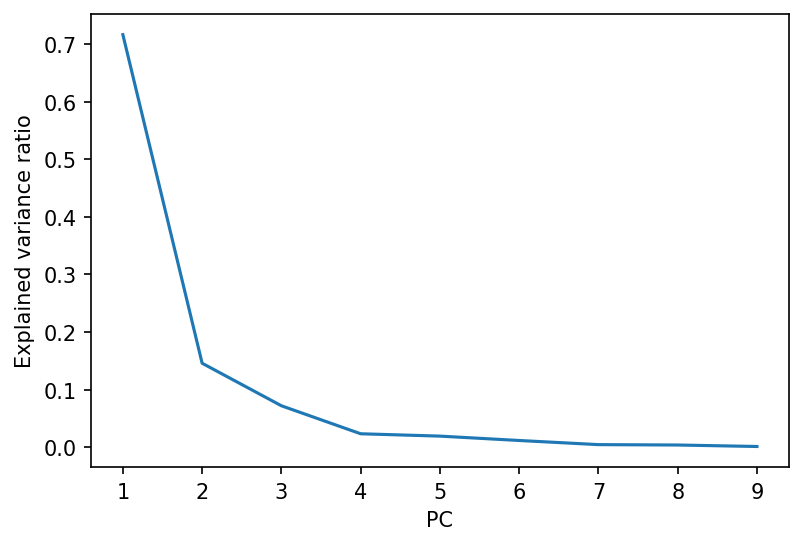

In [7]:
plt.figure(dpi=150)
plt.plot(range(1, 10), pca1.explained_variance_ratio_)
plt.xlabel('PC')
plt.ylabel('Explained variance ratio')

Text(0, 0.5, 'PC2')

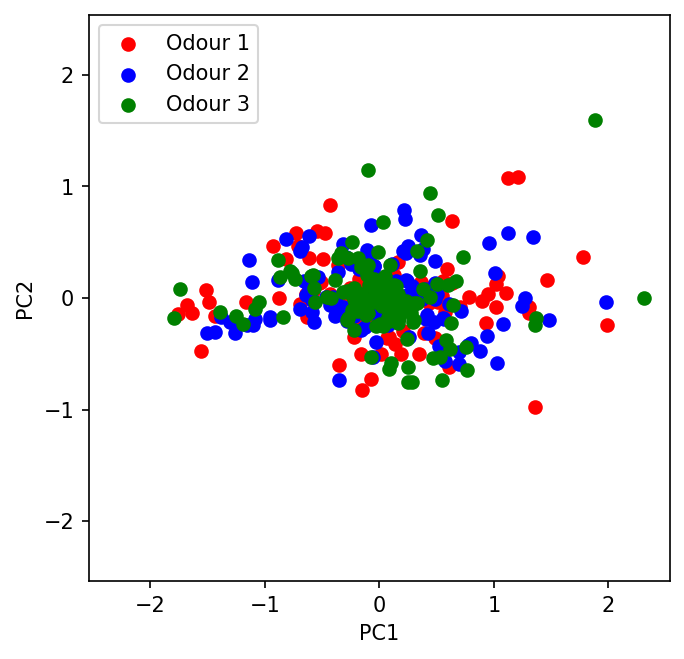

In [14]:
plt.figure(figsize=(5, 5), dpi=150)
plt.scatter(fit_bins1[:, 0], fit_bins1[:, 1], c='r', label='Odour 1')
plt.scatter(fit_bins2[:, 0], fit_bins2[:, 1], c='b', label='Odour 2')
plt.scatter(fit_bins3[:, 0], fit_bins3[:, 1], c='g', label='Odour 3')
plt.legend()
max_lim = np.max(plt.xlim() + plt.ylim())
plt.xlim([-max_lim, max_lim])
plt.ylim([-max_lim, max_lim])
plt.xlabel('PC1')
plt.ylabel('PC2')

Text(0, 0.5, 'PC weights')

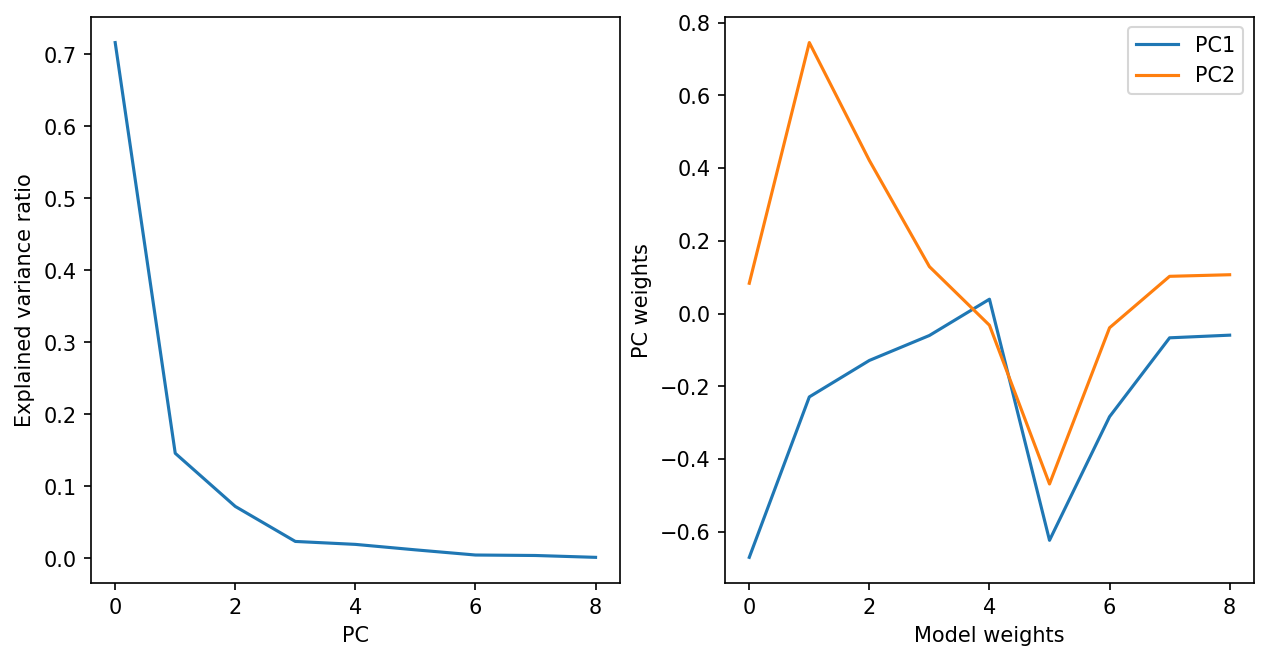

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)
ax[0].plot(pca1.explained_variance_ratio_)
ax[1].plot(pca1.components_[0], label='PC1')
ax[1].plot(pca1.components_[1], label='PC2')
ax[0].set_xlabel('PC')
ax[0].set_ylabel('Explained variance ratio')
ax[1].legend()
ax[1].set_xlabel('Model weights')
ax[1].set_ylabel('PC weights')

In [6]:
pca_half1 = PCA(n_components=9)
pca_half2 = PCA(n_components=9)
model = diff_models1[0]

In [7]:
usrt_split1 = [[train_test_split(i.mean(axis=-1), test_size=0.5) for i in j] for j in unit_usrt1]

In [10]:

all_normed = []
for index in trange(100):
    first_pass_bins = np.array([i.training_opts[index].x[:-1] for i in diff_models1])
    threshes = np.array([i.training_opts[index].x[-1] for i in diff_models1])
    pca = PCA(n_components=9)

    all_fit_errors = []
    all_pred_resps = []
    for pcs in range(0, 10):
        pcad_bins = pca.fit_transform(first_pass_bins)
        pcad_bins[:, pcs:] = 0
        pcad_bins = pca.inverse_transform(pcad_bins)
        [model.fit(W=i.tolist() + [j]) for model, i, j in zip(diff_models1, pcad_bins, threshes)];
        pred_resps = [i.pred_resp for i in diff_models1]
        all_pred_resps.append(pred_resps)
        fit_errors = [np.sum((i.X_test_avg[index] - j)**2) for i, j in zip(diff_models1, pred_resps)]
        all_fit_errors.append(fit_errors)
    all_fit_errors = np.array(all_fit_errors)
    all_pred_resps = np.array(all_pred_resps)
    normed =( all_fit_errors - all_fit_errors.min(axis=0)) / (all_fit_errors.max(axis=0) - all_fit_errors.min(axis=0))
    # for i in normed.T:
    #     plt.plot(i, alpha=0.5, color='lightgray')
    # plt.plot(normed.mean(axis=1))
    # plt.xlabel('Number of PCs')
    # plt.ylabel('Normalized Fit Error')
    all_normed.append(normed)


100%|██████████| 100/100 [00:18<00:00,  5.31it/s]


(100, 10, 130)
(10, 130)


Text(0, 0.5, 'Normalized Fit Error')

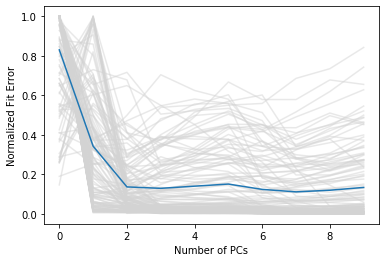

In [18]:
print(np.array(all_normed).shape)
mean_normed = np.array(all_normed).mean(axis=0)
print(mean_normed.shape)
for i in mean_normed.T:
    plt.plot(i, alpha=0.5, color='lightgray')
plt.plot(mean_normed.mean(axis=-1))
plt.xlabel('Number of PCs')
plt.ylabel('Normalized Fit Error')

Text(0.5, 1.0, 'All splits')

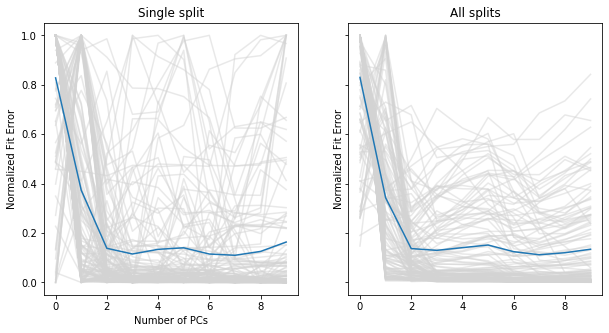

In [27]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 5))
for i in all_normed[0].T:
    ax[0].plot(i, alpha=0.5, color='lightgray')
ax[0].plot(all_normed[0].mean(axis=-1))
ax[0].set_xlabel('Number of PCs')
ax[0].set_ylabel('Normalized Fit Error')

mean_normed = np.array(all_normed).mean(axis=0)
for i in mean_normed.T:
    ax[1].plot(i, alpha=0.5, color='lightgray')
ax[1].plot(mean_normed.mean(axis=-1))
#ax[1].set_xlabel('Number of PCs')
ax[1].set_ylabel('Normalized Fit Error')
ax[0].set_title('Single split')
ax[1].set_title('All splits')

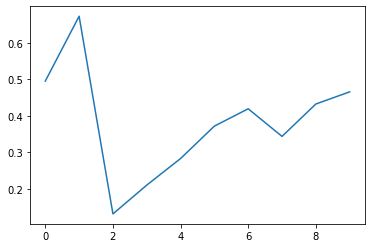

In [37]:
plt.plot(mean_normed[:, 8])

In [39]:
print(np.where(np.argmax(mean_normed, axis=0) == 1))

(array([ 0,  2,  8, 11, 12, 13, 24, 32, 36, 37, 38, 39, 43, 44, 61, 68, 73,
       86, 98]),)


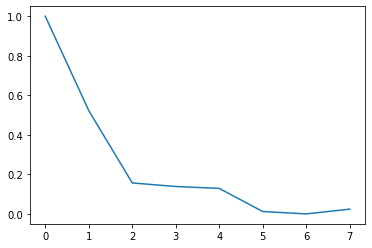

In [178]:
plt.plot(normed[:, 0])

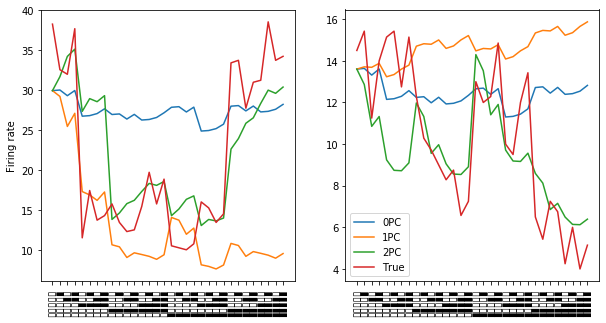

In [58]:
ui = 37
uis = [37, 43]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for i in range(2):
    ui = uis[i]
    ax[i].plot(all_pred_resps[0][ui], label='0PC')
    ax[i].plot(all_pred_resps[1][ui], label='1PC')
    ax[i].plot(all_pred_resps[2][ui], label='2PC')
    ax[i].plot(diff_models1[ui].X_test_avg[index], label='True')
ax[1].legend()
ax[0].set_ylabel('Firing rate')
ax[0].set_xticks(range(32))
ax[0].set_xticklabels(glyphs, rotation=90);
ax[1].set_xticks(range(32))
ax[1].set_xticklabels(glyphs, rotation=90);


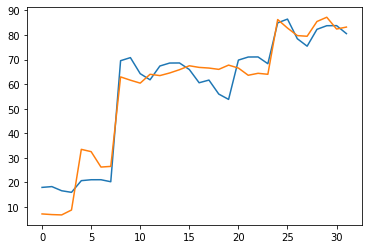

In [127]:
model = diff_models1[40]
plt.plot(model.pred_train_avg[3])
plt.plot(model.true_resp)

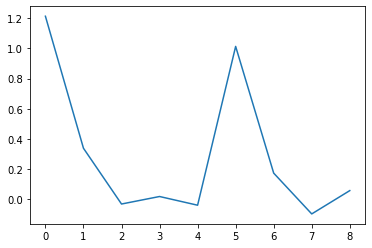

In [159]:
model = diff_models1[40]
w = model.training_opts[3].x[:-1]
plt.plot(w)
# w_pcad = pca.transform([w])
# w_pcad[0, 4:] = 0
# print(w_pcad)
# w = pca.inverse_transform(w_pcad)
# print(w)
# model.fit(W=w[0].tolist() + [model.training_opts[3].x[-1]])
# plt.plot(model.pred_resp)
# plt.plot(model.pred_train_avg[3])
